## TM-TV exercise

0. import resources

In [1]:
import nltk 
from gensim import corpora, similarities
from collections import defaultdict
import gensim 
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
import csv
import ast
import spacy
import os
import warnings
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd


warnings.filterwarnings('ignore') # setting ignore as a parameter

nlp = spacy.load("en_core_web_trf")

print("Libraries imported successfully!")

c:\Users\128525\AppData\Local\Programs\Python\Python39\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Libraries imported successfully!


1. Create the corpus -> dictionary with frequency of words for each document and dictionary with tags associated (for further analysis)

1.1 Choose documents

1.2 Summarize (??)

1.3 Pre processing -> https://www.tutorialspoint.com/gensim/gensim_creating_lda_topic_model.htm 
https://medium.com/nlplanet/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06

1.4 Create the dictionary with frequencies 

In [2]:
path = f'resources/Train.csv'
path_corpus = f'resources/corpus.txt'
path_target = f'resources/target.txt'
features = []

if not os.path.exists(path_corpus):
    texts = []
    targets = []

    with open(path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        i = 0
        for article in reader:
            if i == 0: 
                features = article
                i += 1
            elif i <= 30:
                text = article[1]
                texts.append(text)
                target = []
                for index in range(2, len(article)):
                    if article[index] == "1":
                        target.append(features[index])
                
                targets.append(target)
                i += 1
            else: 
                break
 
    with open (path_corpus, 'w', encoding='utf-8') as f:
        for text in texts:
            f.write('"'+text+'"'+"\n")

    with open (path_target, 'w', encoding='utf-8') as f:
        for target in targets:
            f.write('"'+str(target)+'"'+"\n")

else: 
    texts = []
    with open(path_corpus, 'r', encoding='utf-8') as f:
        texts = f.readlines()
        texts = [text.replace('"', '') for text in texts]

    targets = []
    with open(path_target, 'r', encoding='utf-8') as f:
        targets = f.readlines()
        targets = [ast.literal_eval(target.replace('"', '')) for target in targets]

targets_flat = [item for sublist in targets for item in sublist]
n_topics = len(list(set(targets_flat)))

In [8]:
"""
if not os.path.exists('resource/summaries.txt'):
    summaries = []
    for text in texts:
        # Instantiating the model and tokenizer with gpt-2
        tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
        model=GPT2LMHeadModel.from_pretrained('gpt2')

        # Encoding text to get input ids & pass them to model.generate()
        inputs=tokenizer.batch_encode_plus([text],return_tensors='pt', truncation=True)
        summary_ids=model.generate(inputs['input_ids'],early_stopping=True, pad_token_id=tokenizer.eos_token_id)

        # Decoding and printing summary

        GPT_summary=tokenizer.decode(summary_ids[0],skip_special_tokens=True)
        #print(GPT_summary)
        summaries.append(GPT_summary)

    with open('resource/summaries.txt', 'w', encoding='utf-8') as f:
        for summary in summaries:
            f.write('"'+summary+'"'+"\n")
else: 
    summaries = []
    with open('resource/summaries.txt', 'r', encoding='utf-8') as f:
        summaries = f.readlines()
        summaries = [summary.replace('"', '') for summary in summaries]
"""
print()

2. Create the model 

2.1 Pre processing

2.2 Building Dictionary & Corpus for Topic Model

2.3 Building LDA Topic Model

In [3]:
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

texts_token = []
for text in texts: 
    stopwords = nltk.corpus.stopwords.words('english')
    text_spacy = nlp(text)
    # Remove stopwords
    text_token = [word.lemma_ for word in text_spacy if word.text != "\n" and \
         not word.is_stop and not word.is_punct and not word.like_num and word.text != "I" \
         and word.text not in stopwords and word.pos_ in allowed_postags]
    
    texts_token.append(text_token)


In [4]:
dictionary = corpora.Dictionary(texts_token)
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, random_state=100)
lda_model.show_topics()

[(0,
  '0.011*"method" + 0.010*"consider" + 0.010*"job" + 0.009*"datum" + 0.007*"algorithm" + 0.006*"query" + 0.006*"behavior" + 0.006*"model" + 0.006*"base" + 0.006*"analysis"'),
 (1,
  '0.017*"consider" + 0.008*"model" + 0.008*"low" + 0.007*"point" + 0.007*"work" + 0.007*"datum" + 0.007*"method" + 0.006*"defect" + 0.005*"base" + 0.005*"cascade"'),
 (2,
  '0.023*"consider" + 0.013*"model" + 0.008*"job" + 0.007*"method" + 0.006*"datum" + 0.006*"problem" + 0.006*"e" + 0.006*"image" + 0.006*"analysis" + 0.005*"result"'),
 (3,
  '0.014*"consider" + 0.013*"method" + 0.009*"model" + 0.006*"mass" + 0.006*"asymptotically" + 0.005*"result" + 0.005*"galaxy" + 0.004*"bar" + 0.004*"low" + 0.004*"high"'),
 (4,
  '0.020*"consider" + 0.011*"method" + 0.009*"problem" + 0.007*"spin" + 0.006*"model" + 0.005*"network" + 0.005*"algorithm" + 0.005*"base" + 0.004*"image" + 0.004*"provide"')]

3. Visualizations of the model 

In [5]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.045968  0.023574       1        1  27.843602
4      0.055344 -0.001314       2        1  24.356251
3     -0.002736 -0.022096       3        1  21.977638
1     -0.016969 -0.040207       4        1  16.956971
0      0.010329  0.040044       5        1   8.865538, topic_info=          Term       Freq      Total Category  logprob  loglift
431        job  15.000000  15.000000  Default  30.0000  30.0000
317      point   6.000000   6.000000  Default  29.0000  29.0000
113  algorithm   9.000000   9.000000  Default  28.0000  28.0000
612     defect   5.000000   5.000000  Default  27.0000  27.0000
674      query   6.000000   6.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
150    problem   1.204613  16.953095   Topic5  -5.4895  -0.2213
209    explain   0.867367   5.387152   Topic5  -5.8179   0.5967
156     result   1.075673  15.944631   Topic5  -5.6027  -0.2732
393       time   0.896587   7.809106   Topic5  -5.7848   0.2585
98       study   0.847287   9.495618   Topic5  -5.8414   0.0065

[328 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
112       2  0.567935  2$-matching
804       5  0.559743      account
1064      2  0.417316     accuracy
1064      5  0.417316     accuracy
921       1  0.436281           ad
...     ...       ...          ...
110       2  0.172988         work
110       3  0.172988         work
110       4  0.345975         work
110       5  0.086494         work
1297      2  0.952119          zno

[537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

In [6]:
for i in range(len(texts)):
    print(lda_model[corpus][i])



[(1, 0.99486184)]
[(4, 0.99185735)]
[(3, 0.9942094)]
[(1, 0.99383235)]
[(4, 0.992981)]
[(0, 0.019374756), (2, 0.9768104)]
[(4, 0.9939161)]
[(3, 0.9937146)]
[(2, 0.9676742)]
[(1, 0.9926857)]
[(2, 0.9907197)]
[(3, 0.99470043)]
[(4, 0.99001306)]
[(4, 0.9869978)]
[(0, 0.99309546)]
[(3, 0.9923031)]
[(2, 0.9881879)]
[(2, 0.99132013)]
[(2, 0.99307567)]
[(3, 0.99284506)]
[(1, 0.9944584)]
[(0, 0.99428797)]
[(1, 0.1464958), (3, 0.84744793)]
[(0, 0.51407176), (4, 0.4753056)]
[(2, 0.99433285)]
[(4, 0.9930622)]
[(4, 0.99220276)]
[(2, 0.99151766)]
[(4, 0.989116)]
[(2, 0.99428594)]


4. Evaluation of the model

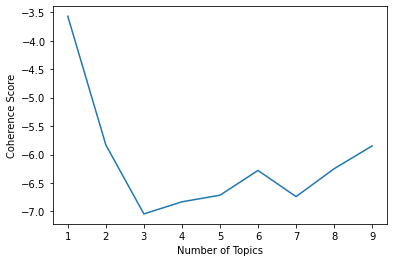

In [7]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

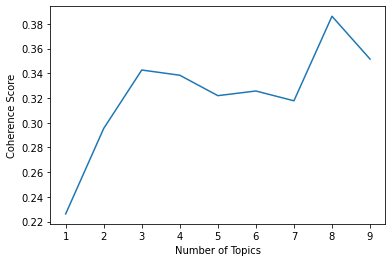

In [8]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, id2word=dictionary,num_topics=i, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, texts = texts_token, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

4. Analysis of the topics using the tags 

In [9]:
topics = [sorted(lda_model[corpus][text])[0][0] for text in range(len(texts))]

topics_df = pd.DataFrame(topics, columns=['topic'])
topics_df['topic'].value_counts().sort_index()

0    4
1    5
2    8
3    5
4    8
Name: topic, dtype: int64

In [10]:
y_topic = topics_df['topic'].values
lda_topics = lda_model.show_topics(formatted=False)

lda_topics = [[word for word, prob in topic] for topicid, topic in lda_topics]

for text in range(len(texts)): 
    print("Text: ", text)
    print("Result model: ", lda_topics[y_topic[text]])
    print("Real tags: ", targets[text])

Text:  0
Result model:  ['consider', 'model', 'low', 'point', 'work', 'datum', 'method', 'defect', 'base', 'cascade']
Real tags:  ['Physics', 'Cosmology and Nongalactic Astrophysics', 'Instrumentation and Methods for Astrophysics']
Text:  1
Result model:  ['consider', 'method', 'problem', 'spin', 'model', 'network', 'algorithm', 'base', 'image', 'provide']
Real tags:  ['Computer Science', 'Data Structures and Algorithms']
Text:  2
Result model:  ['consider', 'method', 'model', 'mass', 'asymptotically', 'result', 'galaxy', 'bar', 'low', 'high']
Real tags:  ['Physics', 'Strongly Correlated Electrons']
Text:  3
Result model:  ['consider', 'model', 'low', 'point', 'work', 'datum', 'method', 'defect', 'base', 'cascade']
Real tags:  ['Physics', 'Fluid Dynamics']
Text:  4
Result model:  ['consider', 'method', 'problem', 'spin', 'model', 'network', 'algorithm', 'base', 'image', 'provide']
Real tags:  ['Computer Science', 'Computer Vision and Pattern Recognition', 'Machine Learning']
Text:  5
R

In [ ]:
# vorrei controllare se effettivamente divisi in argomenti in questo modo i testi sono realmente simili tra loro



